In [1]:
### This is largely inspired by HW2 but adapted to our needs

import numpy as np
import pickle as pkl
from scipy import optimize
import matplotlib.pyplot as plt
from tqdm import tqdm
import cvxpy as cp
import time
import pandas as pd
import copy
from utils import scatter_label_points
from scipy.sparse import load_npz

# Note that we only use a distance computation function from sklearn (for sparse matrices), no learning agorithm from sklearn is used.
from sklearn.metrics import pairwise_distances

In [2]:
test_data = np.load('./test_data.pkl', allow_pickle=True)
training_data = np.load('./training_data.pkl', allow_pickle=True)
training_labels = np.load('./training_labels.pkl', allow_pickle=True)

train_set = training_data[:5000]
train_labels = training_labels[:5000]
val_set = training_data[5000:]
val_labels = training_labels[5000:]

In [3]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd

        # return np.exp( -( (X[...,:,None,:] - Y[...,None,:,:])**2).sum( axis = 2 )/(2.0*self.sigma) )
        # N = X.shape[0]
        # M = Y.shape[0]
        # return np.exp( - ( np.sum(X**2, axis = -1)[:,None] + np.sum(Y**2, axis = -1)[None,:] - 2*np.einsum('ij,kj->ik', X,Y)  )/(2.0*self.sigma) )


        ## LAPLACE 
        # log_result =  - np.sqrt(( (X.power(2)).sum(axis = -1) + ((Y.power(2)).sum(axis = -1)).T - 2*X@(Y.T)  ))/(self.sigma) 
        ## GAUSSIAN 
        # log_result =  - ( (X.power(2)).sum(axis = -1) + ((Y.power(2)).sum(axis = -1)).T - 2*X@(Y.T)  )/(2.0*self.sigma) 

        # result = np.exp(log_result )
        # return result
    
        # # we do a loop because otherwise we have an memory overflow
        # result = np.zeros((X.shape[-2], Y.shape[-2]))
        # # num_simultaneous_calculation = 10

        # for j in tqdm(range(result.shape[0])) :
        #     result[j] = np.exp( -( (X[j,None,:] - Y[:,:])**2).sum( axis = -1 )/(2.0*self.sigma) )
        # return(result)

        ## MIN MAX KERNEL !!
        average = (X.sum(axis=-1) + Y.sum(axis=-1).T)/2.
        difference =  pairwise_distances(X,Y, metric =  "cityblock")/2
    
        max = average + difference
        min = average - difference
        min_max_kernel = min/(max + 0.00000000001)
        return min_max_kernel


In [4]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.y = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any v ariable needed for the rest of the code
        N = len(y)
        y = copy.deepcopy(y)
        y[y==0] = -1

        self.y = y
        self.X = X
        self.support = None
        print("start kernel calculation at", time.time())
        K = self.kernel(X,X)
        print("finish at", time.time())

        ## IMPORTANCE PONDERATION !!
        ponderations = copy.deepcopy(y)
        ponderations[ponderations == 1] = 5455./555. # j'ai l'impression qu'on overfeat avec ça 
        # ponderations[ponderations == 1] = 1.0
        ponderations[ponderations == -1] = 1.0

        ### SECOND version of minimization : FAST ? 
        print("start minimization at ", time.time())
        y = y.reshape((-1,1))
        ponderated_y = ponderations.reshape((-1,1))*y
        ponderations = ponderations.reshape((-1,1))
        n = K.shape[0]
        alpha = cp.Variable((n, 1))
        K_ =  cp.Parameter(K.shape, PSD=True)
        constraints = [cp.multiply(y,alpha) >= 0, cp.multiply(y,alpha) <= self.C]

        objective = cp.Minimize( 0.5*cp.quad_form(cp.multiply(alpha,ponderations),K_)   - cp.sum(cp.multiply(ponderated_y,alpha) )   ) # 0.5*beta.reshape((1,-1))@K@beta - np.sum(alpha)
        problem = cp.Problem(objective, constraints)
        # assert problem.is_dpp() # is not important for us, we optimize only once
        K_.value = K
        problem.solve()


        
        alpha = problem.variables()[0].value * ponderated_y
        self.alpha = alpha.flatten()
        y = y.flatten()
        print("end minimization at ", time.time())
        ponderations = ponderations.flatten()
        ## Assign the required attributes
        print("alpha")
        for a in alpha :
            print(a)
        indices = np.nonzero( (self.alpha > self.epsilon*ponderations)*( self.alpha < ponderations*(self.C - self.epsilon)) )[0]
        print(np.nonzero( (self.alpha > self.epsilon*ponderations)*( self.alpha < ponderations*(self.C - self.epsilon))))
        self.support = X[indices]  #'''------------------- A matrix with each row corresponding to a point that falls on the margin ------------------'''
        print("the support is ",self.support.shape)
        self.b = y[indices[0]] - K[indices[0]]@(self.alpha*y) #''' -----------------offset of the classifier------------------ '''
        self.b = np.mean(y[indices] - K[indices]@(self.alpha*y)) #''' -----------------offset of the classifier------------------ '''

        beta = y*self.alpha
        self.norm_f = beta.reshape((1,-1))@K@beta  # '''------------------------RKHS norm of the function f ------------------------------'''


    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        output = (self.alpha*self.y).reshape((1,-1))@self.kernel(self.X,x)
        return output.flatten()
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b) - 1

In [5]:
"""
notes :
WE SOLVED MINIMIZATION YOUHOOOOO : now kernel calculation is the choke point because it takes too much space to do all at once.

for max_size_subgraph = 2 it takes about 15 seconds to calculate the kernel + 10 sec for vectorization + ? minutes for minimization = 2m20 YOUHOUUUUUU 
for max_size_subgraph = 5 it takes about 100 seconds for vectorization + 75 secs to calculate the kernel + 60 secs for minimization = 4.20 mins 
for max_size_subgraph = 10 it takes about    seconds for vectorization +  secs to calculate the kernel +  secs for minimization = ,,, mins 
"""

'\nnotes :\nWE SOLVED MINIMIZATION YOUHOOOOO : now kernel calculation is the choke point because it takes too much space to do all at once.\n\nfor max_size_subgraph = 2 it takes about 15 seconds to calculate the kernel + 10 sec for vectorization + ? minutes for minimization = 2m20 YOUHOUUUUUU \nfor max_size_subgraph = 5 it takes about 100 seconds for vectorization + 75 secs to calculate the kernel + 60 secs for minimization = 4.20 mins \nfor max_size_subgraph = 10 it takes about    seconds for vectorization +  secs to calculate the kernel +  secs for minimization = ,,, mins \n'

In [6]:
# sigma = 1.5
sigma = 1.
C= 5.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)


# train_set_length = len(train_set)
# val_set_length = len(val_set)
# Graphs = train_set + val_set 

# X = common_subgraph_vectorization(Graphs, 12)

# X_train = X[:train_set_length]
# X_val = X[train_set_length:]

max_subgraph_size = 10

X_training = load_npz('./vectorizations/X_train_max_subgraph_' + str(max_subgraph_size) + '.npz')
X_train = X_training[:5000]
X_val = X_training[5000:]

print("size of the vectors is ", X_train[0].shape)

model.fit(X_train,train_labels)


size of the vectors is  (1, 711988)
start kernel calculation at 1681242799.781169
finish at 1681242807.1633515
start minimization at  1681242807.1636417


/home/roland/miniconda3/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:200: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


end minimization at  1681242917.072869
alpha
[0.63148957]
[0.79899545]
[6.33549868e-20]
[0.40932198]
[3.58631533]
[1.8300929]
[0.43717057]
[-6.83232767e-21]
[5.78722039e-22]
[-3.94600903e-20]
[-6.35527322e-20]
[0.1993066]
[-4.15833339e-21]
[-9.11249834e-21]
[2.14468328]
[1.89704778e-20]
[0.26464026]
[1.74602867]
[4.46131753e-19]
[0.5893812]
[-1.61374705e-20]
[0.51254473]
[-1.36057493e-20]
[0.21038264]
[0.05415312]
[0.03677458]
[0.80205309]
[0.0452841]
[0.0419685]
[0.55568481]
[0.69188352]
[0.25746579]
[0.16267927]
[0.91896968]
[-1.30479852e-20]
[0.15630494]
[0.94618224]
[0.4406533]
[8.17159726e-20]
[1.07826094]
[2.73196385e-21]
[1.31619085]
[0.74431905]
[0.74293935]
[0.96938957]
[-1.5195349e-20]
[0.28684525]
[1.41593505]
[0.14879642]
[1.13560435]
[1.58825598]
[0.71748103]
[0.44269455]
[-6.27587875e-21]
[0.15527549]
[0.03443603]
[0.16718055]
[2.01583101]
[0.09942679]
[0.69500828]
[0.09530762]
[-1.04200838e-20]
[0.27305914]
[0.87690259]
[-1.79511425e-19]
[-1.78474903e-20]
[-1.16416766e-1

In [7]:
### IDEA 

In [8]:
estimated_val_labels = np.array(model.predict(X_val)).flatten()


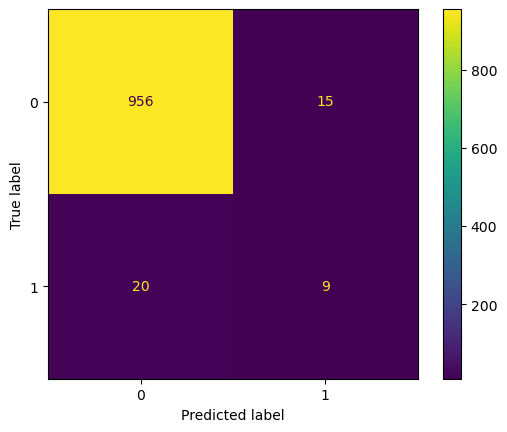

In [9]:
import matplotlib.pyplot as plt
from sklearn import metrics

estimated_val_labels_rounded = ((estimated_val_labels + 1)/2 >0).astype('int')
actual = val_labels.flatten()
predicted = np.array(estimated_val_labels_rounded).flatten()

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

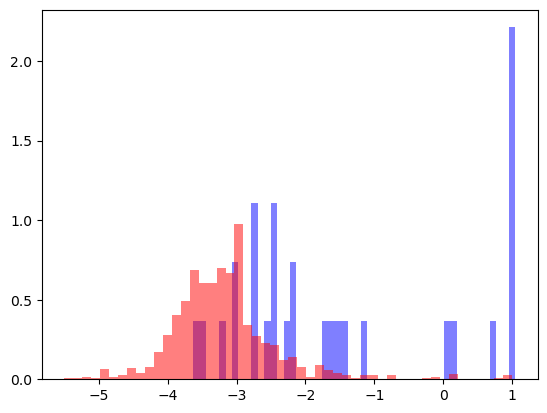

In [10]:
true_ones_indexes = np.argwhere(val_labels == 1)

bins = 50
plt.hist( estimated_val_labels[val_labels == 1],bins = bins, density = True, alpha=0.5, color = 'b' )
plt.hist( estimated_val_labels[val_labels == 0],bins = bins, density = True, alpha=0.5, color = 'r' )
plt.show()

In [11]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(val_labels, estimated_val_labels)
print(auc)

0.8685322632195746


In [12]:
# max_8 not ponderated  :::: AUC = 0.8706452643914911
# max_8 ponderated  :::: AUC = 0.8662416989239674
# max_10 sans pondéeation :::: AUC = 0.8685322632195746

(5000,)
(5000,)
(5000,)


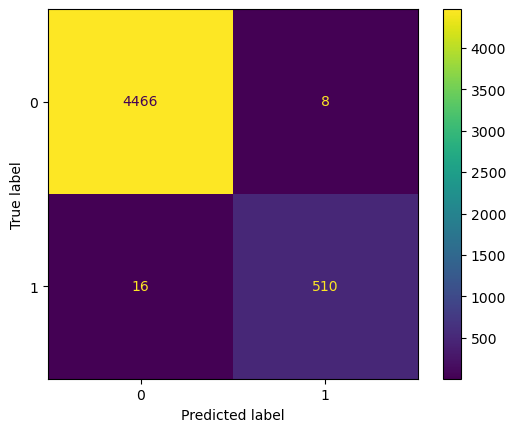

In [13]:
estimated_train_labels = np.array(model.predict(X_train)).flatten()
print(estimated_train_labels.shape)
estimated_train_labels_rounded = (((estimated_train_labels + 1)/2) > 0 ).astype('int') 

actual = train_labels.flatten()
predicted =  np.array(estimated_train_labels_rounded).flatten()
print(actual.shape)
print(predicted.shape)
confusion_matrix = metrics.confusion_matrix(actual, predicted) 

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

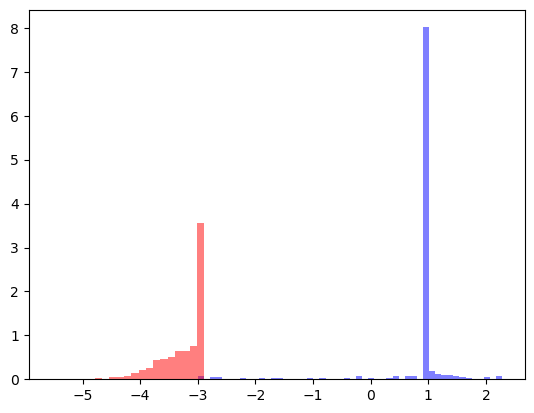

In [14]:
true_ones_indexes = np.argwhere(val_labels == 1)

bins = 50
plt.hist( estimated_train_labels[train_labels == 1],bins = bins, density = True, alpha=0.5, color = 'b' )
plt.hist( estimated_train_labels[train_labels == 0],bins = bins, density = True, alpha=0.5, color = 'r' )
plt.show()

In [15]:
class KernelPCA:
    
    def __init__(self,kernel, r=2):                             
        self.kernel = kernel          # <---
        self.alpha = None # Matrix of shape N times d representing the d eingenvectors alpha corresp
        self.lmbda = None # Vector of size d representing the top d eingenvalues
        self.support = None # Data points where the features are evaluated
        self.r =r ## Number of principal components
    def compute_PCA(self, X):
        # assigns the vectors
        self.support = X
        N = X.shape[0]
        K = kernel(X,X)
        G = K - 1.0/N*np.ones((N,N))@K - 1.0/N*K@np.ones((N,N)) + 1.0/N**2*np.ones((N,N))@K@np.ones((N,N))
        lmbda, alpha = np.linalg.eigh(G)
        lmbda = lmbda[::-1]
        alpha = alpha[:, ::-1]
        
#         lmbda, alpha = np.real(lmbda), np.real(alpha)
        
#         alpha = alpha/np.sqrt( np.einsum("ij,j",[alpha.T@G@alpha ) )
        self.lmbda = lmbda[0:self.r]
        self.alpha = alpha[:,0:self.r]
        for j in range(self.r) :
            self.alpha[:,j] = self.alpha[:,j]/np.sqrt(self.alpha[:,j].reshape((1,-1))@G@self.alpha[:,j].reshape((-1,1)) )
        
        #constraints = ({})
        # Maximize by minimizing the opposite
        
    def transform(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        K = self.kernel(self.support, x)
        N1, N2 = K.shape
        reponse = K - np.ones((N1,N1))/N1@K \
                 - K@np.ones((N2,N2))/N2 +  np.ones((N1,N1))/N1@K@np.ones((N2,N2))/N2
        return( reponse.T@self.alpha )
    


In [16]:

# train_set = X_train 
# val_set = X_val

# sigma = 0.1
# kernel = RBF(sigma).kernel
# pca = KernelPCA(kernel, r=3 )
# pca.compute_PCA(train_set)
# pca_components = pca.transform(val_set)

# fig, ax = plt.subplots(1,2, figsize=(11, 4))
# scatter_label_points(val_set, val_labels, ax[0], title='orginal data')
# scatter_label_points(pca_components[:,:2],val_labels, ax[1], title= 'transformed data')

# fig, ax = plt.subplots(1,3, figsize=(11, 4))
# scatter_label_points(val_set, val_labels, ax[0], title='orginal data')
# scatter_label_points(pca_components[:,1:3],val_labels, ax[1], title= 'along with second and third eigenvectors')
# scatter_label_points(pca_components[:,::2],val_labels, ax[2], title= 'along with first and third eigenvectors')


In [17]:
## this is to make the real predictions 



In [18]:
test_data = np.load('./test_data.pkl', allow_pickle=True)
training_data = np.load('./training_data.pkl', allow_pickle=True)
training_labels = np.load('./training_labels.pkl', allow_pickle=True)

In [19]:

kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)


# train_set_length = len(training_data)
# test_set_length = len(test_data)
# Graphs = training_data + test_data 

# X = common_subgraph_vectorization(Graphs, 5)

# X_train = X[:train_set_length]
# X_test = X[train_set_length:]

X_training = load_npz('./vectorizations/X_train_max_subgraph_' + str(max_subgraph_size) + '.npz')
X_test = load_npz('./vectorizations/X_test_max_subgraph_' + str(max_subgraph_size) + '.npz')


model.fit(X_training,training_labels)


start kernel calculation at 1681242928.1338959
finish at 1681242938.4476285
start minimization at  1681242938.4479434


/home/roland/miniconda3/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:200: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


end minimization at  1681243106.200495
alpha
[0.47516555]
[0.75800793]
[-5.33326725e-20]
[0.40804478]
[3.59236531]
[1.90112286]
[0.10504084]
[-1.50709235e-19]
[-8.16535138e-20]
[-2.72692288e-21]
[-1.71916577e-20]
[0.19714956]
[0.00174879]
[-5.08595736e-21]
[2.16168337]
[5.63766155e-20]
[0.1159603]
[1.75120595]
[-1.00619456e-19]
[0.61043825]
[1.16656542e-20]
[0.54732402]
[-3.00868418e-20]
[0.21104115]
[0.00124493]
[0.02581579]
[0.79826659]
[0.05163489]
[0.01705103]
[0.62441962]
[0.48345543]
[0.2472625]
[0.15509101]
[0.92717432]
[2.44621577e-20]
[0.13986808]
[1.05277115]
[0.39376268]
[-4.58365006e-20]
[1.10265341]
[-2.50796091e-20]
[1.35070307]
[0.74285957]
[0.77153091]
[0.56566236]
[-5.25836653e-20]
[0.31634759]
[1.44939245]
[0.14439108]
[1.10138588]
[1.59911894]
[0.3576997]
[0.42928651]
[-5.66430392e-21]
[0.13665698]
[0.02672221]
[-1.10143989e-18]
[2.06004972]
[0.06275612]
[0.69474357]
[0.07134391]
[1.12410119e-20]
[0.25632912]
[0.88898111]
[4.2945095e-21]
[-3.98808138e-21]
[2.0425022e

In [20]:
"""
for 5 subgraph max size we have 
vectorization : 186 sec  kernel : 132 secs   minimization : 143secs 
sigma = 1.5  C=100.  gives support of shape (526, 5219) 

"""

'\nfor 5 subgraph max size we have \nvectorization : 186 sec  kernel : 132 secs   minimization : 143secs \nsigma = 1.5  C=100.  gives support of shape (526, 5219) \n\n'

In [21]:
estimated_test_labels = np.array(model.predict(X_test)).flatten()


In [22]:
print(estimated_test_labels)

[-2.96821025 -2.64967256 -2.49284874 ... -2.77192473  0.33987272
 -3.35210134]


In [23]:
for x in estimated_test_labels:
    print(x)

-2.9682102490454945
-2.649672564867064
-2.4928487411528764
-2.7334208026610947
-1.7187301979026193
-2.574924728317842
-1.863940663948566
-3.1206644429246477
-2.6305507835235415
-3.147814318563361
-2.9010261179876373
-3.0109059845540456
-0.7992709842580183
-3.3191818518523117
-3.310906151514236
-2.8908569507954693
-3.436165508163943
-2.7607737016256033
-2.5665381068809276
-1.1066307139850597
-2.590712797585666
-2.8023494113242897
-1.943958677960348
-2.648209236006669
-3.0927402197593046
-3.0220385492067843
-2.526385062004125
-1.7716252160116241
-2.512904421322289
-2.5969292877436563
-1.5992097755323027
-3.147814318563361
-2.842292209949391
-2.6679153458748055
-2.443148442998523
-2.7177009046376
-3.122331711497581
-3.01740673150674
-1.4302370414288916
-2.832047645384196
-2.842292209949391
-1.5413084320390766
-3.4655643839950496
-3.152325656552022
-2.574924728317842
-3.2641485951629408
-2.337857554894386
-2.9364307496787596
-1.4384874459972317
-2.439857452371121
-2.8908569507954693
-2.855

In [24]:

Yte = {'Predicted' : np.round(np.array(estimated_test_labels).flatten(),3)} 
df = pd.DataFrame(Yte) 
df.index += 1 
df.to_csv('test_pred.csv',index_label='Id')

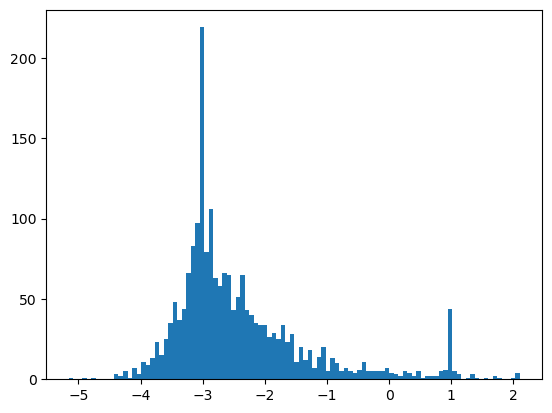

In [25]:
plt.hist(np.array(estimated_test_labels).flatten(), bins = 100)
plt.show()